In [1]:
!pip install blocksnet ipykernel -q

In [2]:
!pip install folium matplotlib mapclassify

In [3]:
!pip install pandera

In [4]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import momepy
import os

In [5]:
boundary = gpd.read_file('/content/boundaries.geojson')
roads = gpd.read_file('/content/road_KN.geojson')
railways = gpd.read_file('/content/railway.geojson')

In [6]:
local_crs = boundary.estimate_utm_crs()

In [7]:
boundary = boundary.reset_index()[['geometry']].to_crs(local_crs)
roads = roads.reset_index()[['geometry']].to_crs(local_crs)
railways = railways.reset_index()[['geometry']].to_crs(local_crs)

In [8]:
roads = roads[roads.geom_type.isin(['LineString', 'MultiLineString'])]
railways = roads[roads.geom_type.isin(['LineString', 'MultiLineString'])]

In [9]:
GAP_TOLERANCE = 1
def _get_roads(roads):
    merged = roads.unary_union
    if merged.geom_type == 'MultiLineString':
        roads = gpd.GeoDataFrame(geometry=list(merged.geoms), crs=roads.crs)
    else:
        roads = gpd.GeoDataFrame(geometry=[merged], crs=roads.crs)
    roads = roads.explode(index_parts=False).reset_index(drop=True)
    roads.geometry = momepy.close_gaps(roads, GAP_TOLERANCE)
    roads = roads[roads.geom_type.isin(['LineString'])]
    return roads

roads = _get_roads(roads)
roads

,geometry
0,"LINESTRING (530616.442 6733088.814, 530618.296..."
1,"LINESTRING (530834.068 6732109.041, 530948.969..."
2,"LINESTRING (530954.337 6732118.796, 531070.167..."
3,"LINESTRING (530296.693 6731504.304, 530289.836..."
4,"LINESTRING (530264.657 6731740.172, 530264.579..."
...,...
877,"LINESTRING (531590.872 6731686.473, 531619.971..."
878,"LINESTRING (531619.971 6731541.355, 531621.655..."
879,"LINESTRING (531480.136 6731608.549, 531482.410..."
880,"LINESTRING (531482.410 6731597.159, 531511.966..."


In [10]:
GAP_TOLERANCE = 1
def _get_railways(railways):
    merged = railways.unary_union
    if merged.geom_type == 'MultiLineString':
        railways = gpd.GeoDataFrame(geometry=list(merged.geoms), crs=railways.crs)
    else:
        railways = gpd.GeoDataFrame(geometry=[merged], crs=railways.crs)
    railways = railways.explode(index_parts=False).reset_index(drop=True)
    railways.geometry = momepy.close_gaps(railways, GAP_TOLERANCE)
    railways = railways[railways.geom_type.isin(['LineString'])]
    return railways

railways = _get_railways(railways)
railways

,geometry
0,"LINESTRING (530616.442 6733088.814, 530618.296..."
1,"LINESTRING (530834.068 6732109.041, 530948.969..."
2,"LINESTRING (530954.337 6732118.796, 531070.167..."
3,"LINESTRING (530296.693 6731504.304, 530289.836..."
4,"LINESTRING (530264.657 6731740.172, 530264.579..."
...,...
877,"LINESTRING (531590.872 6731686.473, 531619.971..."
878,"LINESTRING (531619.971 6731541.355, 531621.655..."
879,"LINESTRING (531480.136 6731608.549, 531482.410..."
880,"LINESTRING (531482.410 6731597.159, 531511.966..."


In [11]:
from blocksnet import BlocksGenerator

bg = BlocksGenerator(boundary, roads, None, railways)

2025-01-22 17:52:15.232 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:99 - Check boundaries schema
/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
2025-01-22 17:52:16.372 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:103 - Check roads schema
2025-01-22 17:52:16.420 | INFO     | blocksnet.preprocessing.blocks_gener

In [12]:
blocks = bg.run()

2025-01-22 17:52:16.546 | INFO     | blocksnet.preprocessing.blocks_generator:run:161 - Generating blocks
2025-01-22 17:52:16.582 | INFO     | blocksnet.preprocessing.blocks_generator:run:170 - Setting up enclosures
2025-01-22 17:52:16.804 | INFO     | blocksnet.preprocessing.blocks_generator:run:174 - Filling holes
2025-01-22 17:52:16.847 | INFO     | blocksnet.preprocessing.blocks_generator:run:178 - Dropping overlapping blocks
2025-01-22 17:52:16.909 | INFO     | blocksnet.preprocessing.blocks_generator:run:192 - Calculating blocks area
2025-01-22 17:52:16.920 | INFO     | blocksnet.preprocessing.blocks_generator:run:199 - Blocks generated


In [13]:
blocks.explore()

In [14]:
buildings = ox.features_from_polygon(boundary.to_crs(4326).unary_union, {'building': True})

In [15]:
buildings

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


addr:housenumber                     addr:street  \
element_type osmid                                                         
node         3838626253              NaN                             NaN   
way          33499175                 31                 улица Плеханова   
             33499176                  8               Паромный переулок   
             33499177                 56           улица Розы Люксембург   
             33499178                  9  переулок имени Николая Шалаева   
...                                  ...                             ...   
             1352847306              NaN                             NaN   
relation     9093198                 54А                 проспект Ленина   
             9093200                  18               Ульяновская улица   
             9093201                 NaN                             NaN   
             14660906                 13                  улица Гагарина   

                                                                  geometry  \
element_type osmid                                                           
node         3838626253                          POINT (33.54226 60.73667)   
way          33499175    POLYGON ((33.53485 60.72972, 33.53483 60.72961...   
             33499176    POLYGON ((33.50615 60.73609, 33.50641 60.73620...   
             33499177    POLYGON ((33.57836 60.71953, 33.57837 60.71941...   
             33499178    POLYGON ((33.52810 60.73160, 33.52810 60.73151...   
...                                                                    ...   
             1352847306  POLYGON ((33.55051 60.73520, 33.55097 60.73522...   
relation     9093198     POLYGON ((33.53643 60.73591, 33.53642 60.73633...   
             9093200     POLYGON ((33.54640 60.73886, 33.54656 60.73885...   
             9093201     POLYGON ((33.54630 60.73892, 33.54641 60.73893...   
             14660906    POLYGON ((33.54361 60.73536, 33.54361 60.73545...   

                        historic    building  \
element_type osmid                             
node         3838626253      NaN     college   
way          33499175        NaN         yes   
             33499176        NaN         yes   
             33499177        NaN         yes   
             33499178        NaN         yes   
...                          ...         ...   
             1352847306      NaN         yes   
relation     9093198         NaN         yes   
             9093200         NaN         yes   
             9093201         NaN         yes   
             14660906        NaN  apartments   

                                                                     name  \
element_type osmid                                                          
node         3838626253  Лодейнопольский техникум промышленных технологий   
way          33499175                                                 NaN   
             33499176                                                 NaN   
             33499177                                                 NaN   
             33499178                                                 NaN   
...                                                                   ...   
             1352847306                                               NaN   
relation     9093198                                                  NaN   
             9093200                                                  NaN   
             9093201                                                  NaN   
             14660906                                                 NaN   

                         ref  \
element_type osmid             
node         3838626253  NaN   
way          33499175    NaN   
             33499176    NaN   
             33499177    NaN   
             33499178    NaN   
...                      ...   
             1352847306  NaN   
relation     9093198     NaN   
             9093200     NaN   
             9093201     NaN   
         

In [16]:
buildings = buildings.to_crs(local_crs).reset_index()[['geometry']]
buildings.geometry = buildings.representative_point()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
from blocksnet import BlocksSplitter

bs = BlocksSplitter(blocks, buildings)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
splitted_blocks = bs.run()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2025-01-22 17:52:24.864 | INFO     | blocksnet.preprocessing.blocks_splitter:run:167 - Joining buildings and blocks to exclude duplicates
2025-01-22 17:52:25.016 | INFO     | blocksnet.preprocessing.blocks_splitter:run:176 - Choosing blocks to be splitted
2025-01-22 17:52:25.128 | INFO     | blocksnet.preprocessing.blocks_splitter:run:185 - Splitting filtered blocks
100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


In [19]:
len(blocks), len(splitted_blocks)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(249, 266)

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


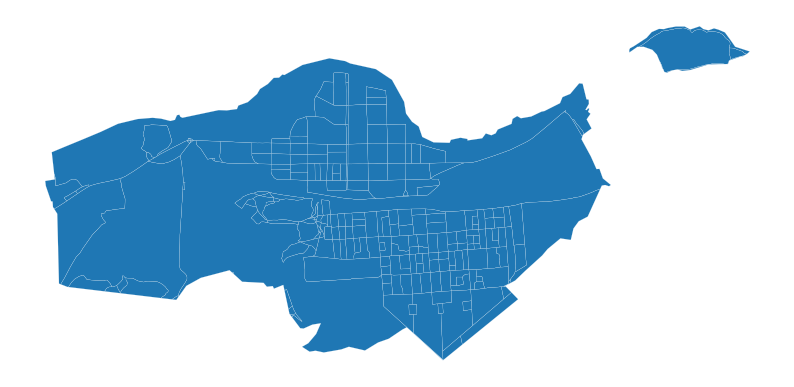

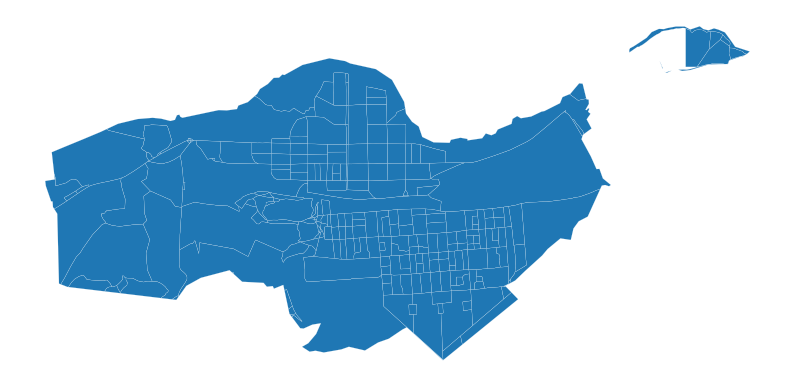

In [20]:
blocks.plot(linewidth=0.1, figsize=(10,10)).set_axis_off()
splitted_blocks.plot(linewidth=0.1, figsize=(10,10)).set_axis_off()

In [21]:
splitted_blocks.to_file('blocks.geojson')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
!pip install iduedu

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
boundary.to_crs(4326, inplace=True)

In [24]:
CRS = 32636
SPEED_M_MIN = 1000

import networkx as nx

def _roads_to_graph(roads):
    graph = momepy.gdf_to_nx(roads)
    graph.graph['crs'] = roads.crs.to_epsg()
    graph = nx.DiGraph(graph)
    for _, _, data in graph.edges(data=True):
        geometry = data['geometry']
        data['time_min'] = geometry.length / SPEED_M_MIN
        # data['weight'] = data['mm_len'] / 1000 / 1000
        # data['length_meter'] = data['mm_len'] / 1000
    for n, data in graph.nodes(data=True):
        graph.nodes[n]['x'] = n[0]  # Assign X coordinate to node
        graph.nodes[n]['y'] = n[1]

    return graph

roads_G = _roads_to_graph(roads)
roads_G

In [25]:
from blocksnet import AccessibilityProcessor
AccessibilityProcessor._fix_graph(roads_G)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


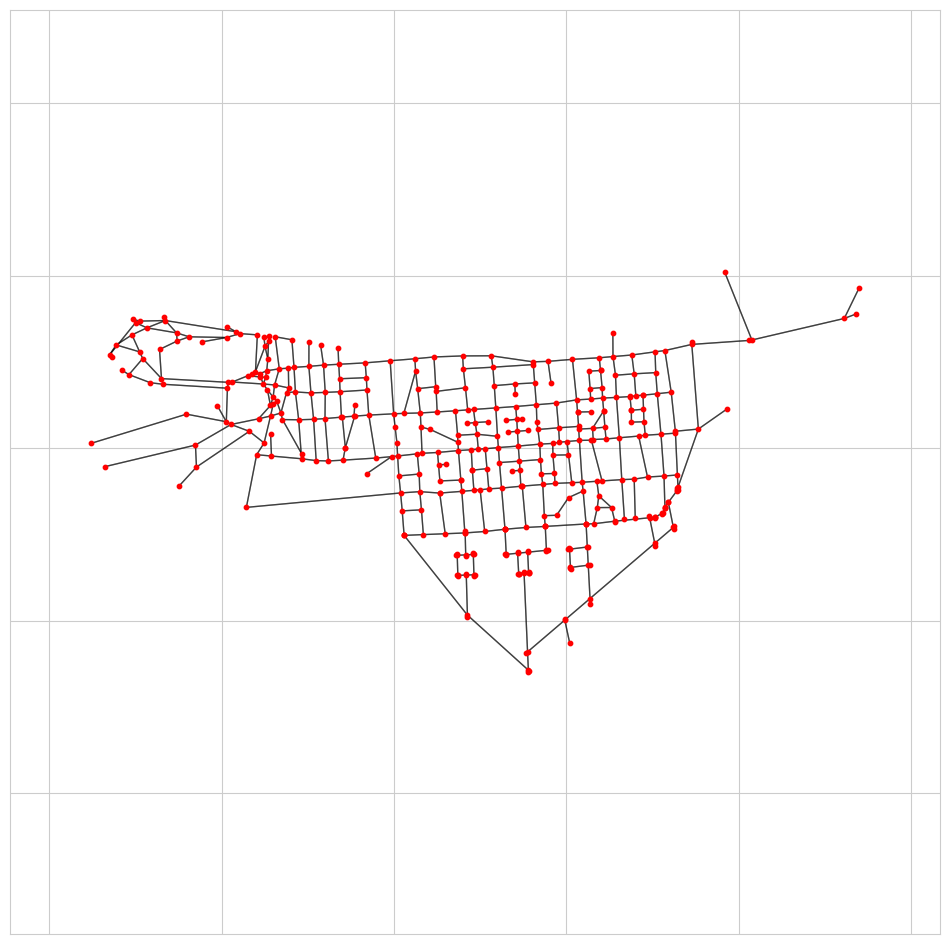

In [26]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(12, 12))
pos = {n: (data['x'], data['y']) for n, data in roads_G.nodes(data=True)}  # Получаем позиции узлов

nx.draw_networkx_edges(roads_G, pos, alpha=0.5, edge_color='black', arrows=False)
nx.draw_networkx_nodes(roads_G, pos, node_color='red', node_size=10)

# plt.title("Визуализация графа дорог")
plt.axis('equal')  # Сохраняем пропорции
plt.show()

In [27]:
from blocksnet import AccessibilityProcessor

ap = AccessibilityProcessor(blocks)
acc_mx = ap.get_accessibility_matrix(roads_G)
acc_mx.head() # вывод первых 5 строк полученной матрицы

,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,248
0,0.000000,0.166138,0.966797,0.661621,1.050781,0.948242,0.982910,1.162109,0.277588,2.419922,...,0.000000,2.447266,2.447266,1.980469,2.105469,1.989258,2.085938,1.527344,1.837891,1.436523
1,0.166138,0.000000,0.800781,0.495361,0.884277,0.781738,1.126953,1.325195,0.443848,2.585938,...,0.166138,2.281250,2.281250,1.829102,1.940430,1.837891,1.935547,1.376953,1.670898,1.580078
2,0.966797,0.800781,0.000000,0.305420,0.083496,0.320557,0.903320,1.114258,1.244141,2.900391,...,0.966797,2.423828,2.423828,1.397461,1.140625,1.406250,1.503906,0.944824,0.872559,1.352539
3,0.661621,0.495361,0.305420,0.000000,0.388916,0.306396,1.055664,1.262695,0.938965,2.673828,...,0.661621,2.271484,2.271484,1.559570,1.445312,1.568359,1.665039,1.106445,1.175781,1.505859
4,1.050781,0.884277,0.083496,0.388916,0.000000,0.237183,0.986816,1.197266,1.328125,2.984375,...,1.050781,2.341797,2.341797,1.467773,1.066406,1.477539,1.574219,1.028320,0.797852,1.435547


In [28]:
from blocksnet.models import City
from blocksnet import Accessibility, Connectivity

blocks['land_use'] = None

city = City(
    blocks=blocks,
    acc_mx=acc_mx
)

connectivity = Connectivity(city_model=city)
connectivity_result = connectivity.calculate()
connectivity_result

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,geometry,connectivity
id,,
0,"POLYGON ((530616.442 6733088.814, 530618.296 6...",1.240234
1,"POLYGON ((530618.296 6733011.050, 530616.442 6...",1.333984
2,"POLYGON ((530834.068 6732109.041, 530948.969 6...",1.657227
3,"POLYGON ((530948.969 6732118.419, 530834.068 6...",1.475586
4,"POLYGON ((530954.337 6732118.796, 531070.167 6...",1.740234
...,...,...
244,"POLYGON ((530425.487 6731032.475, 530778.964 6...",2.369141
245,"POLYGON ((530778.964 6730713.098, 530780.806 6...",2.253906
246,"POLYGON ((530722.879 6731272.849, 530716.502 6...",2.093750


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


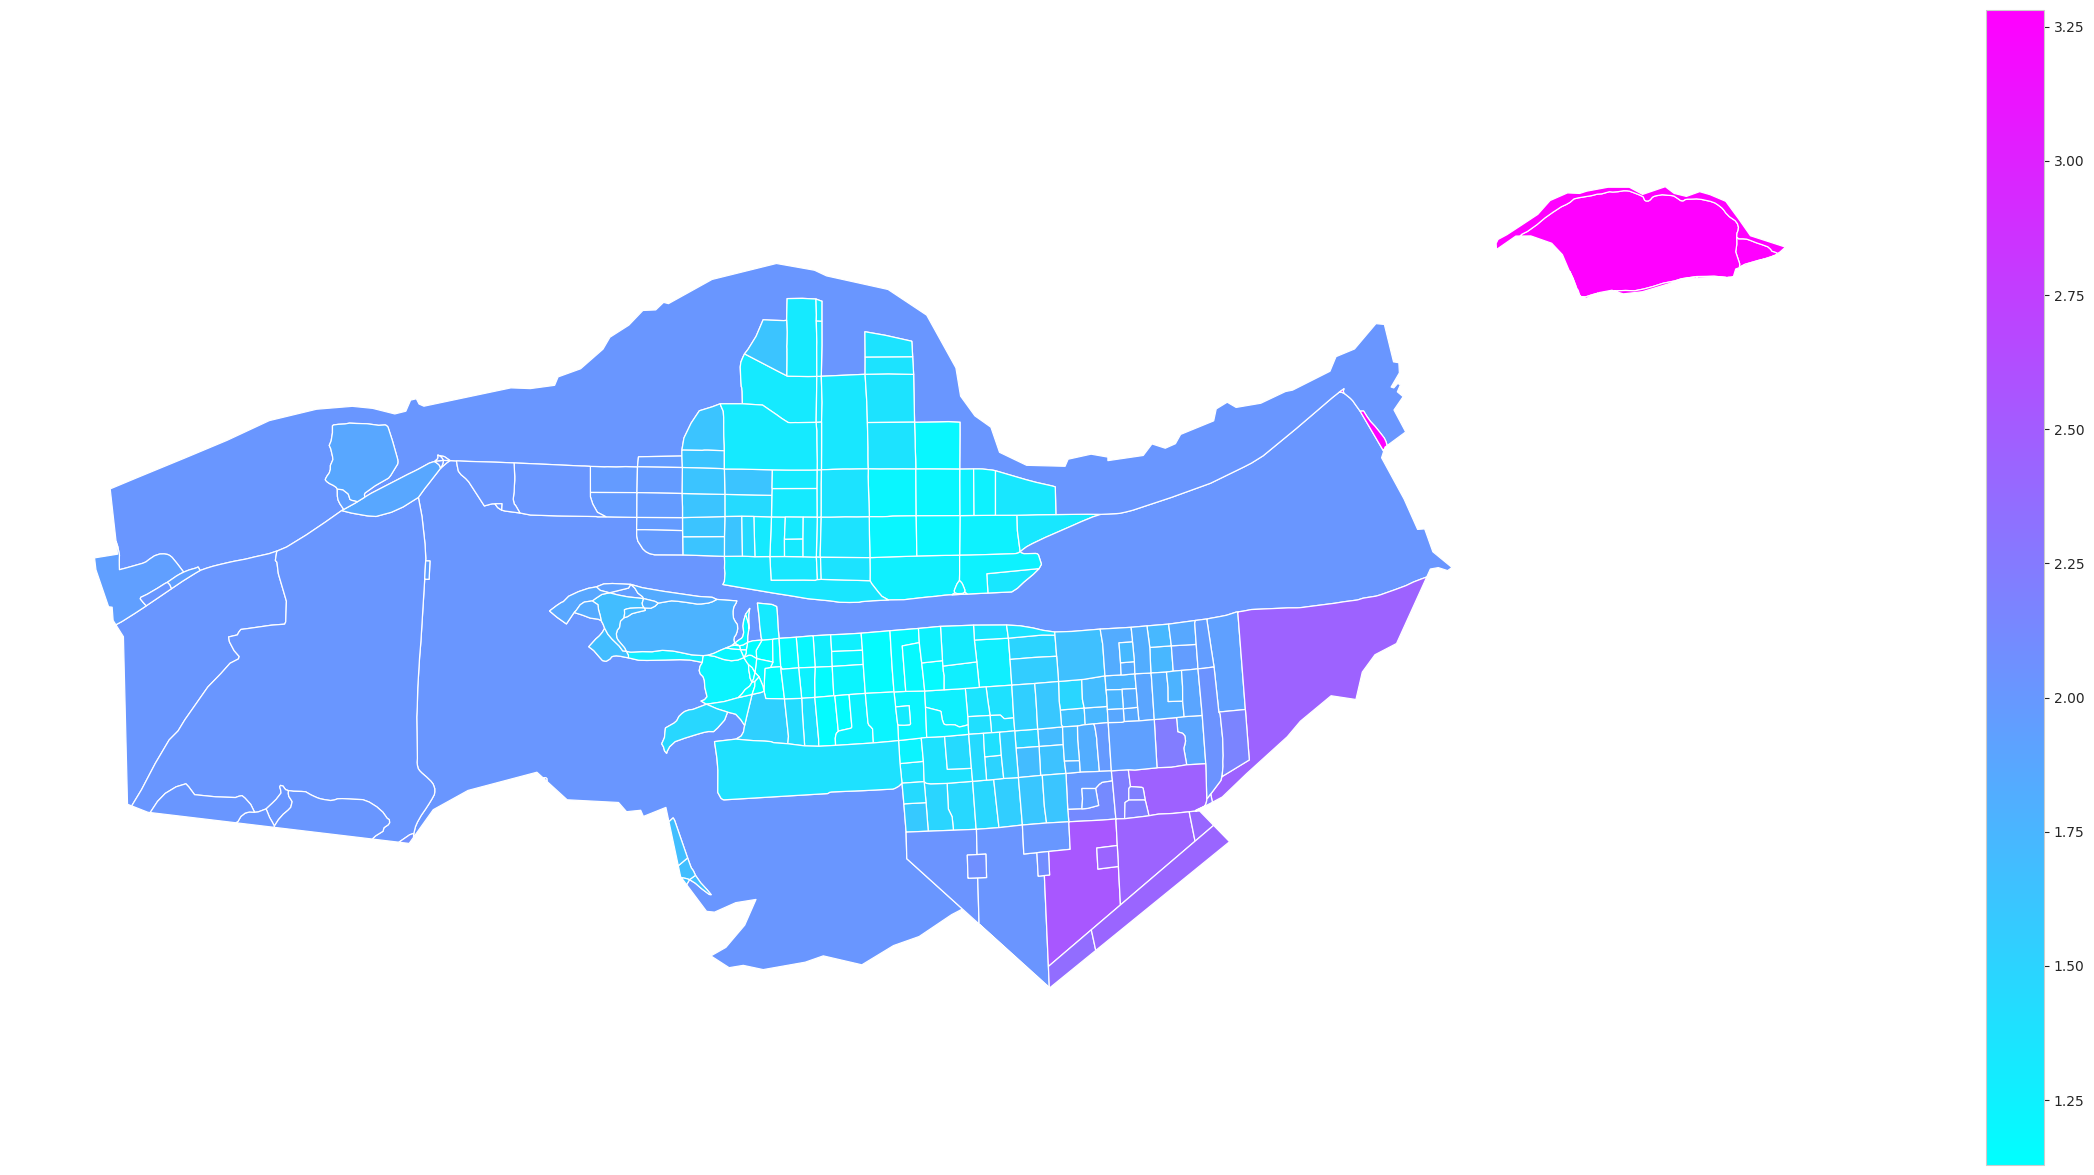

In [29]:
Connectivity.plot(connectivity_result, linewidth=0.9, figsize=(30,15))

In [30]:
accessibility = Accessibility(city_model=city)
block = city[183] # квартал от которого будем считать доступность
result = accessibility.calculate(block)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
result.explore()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


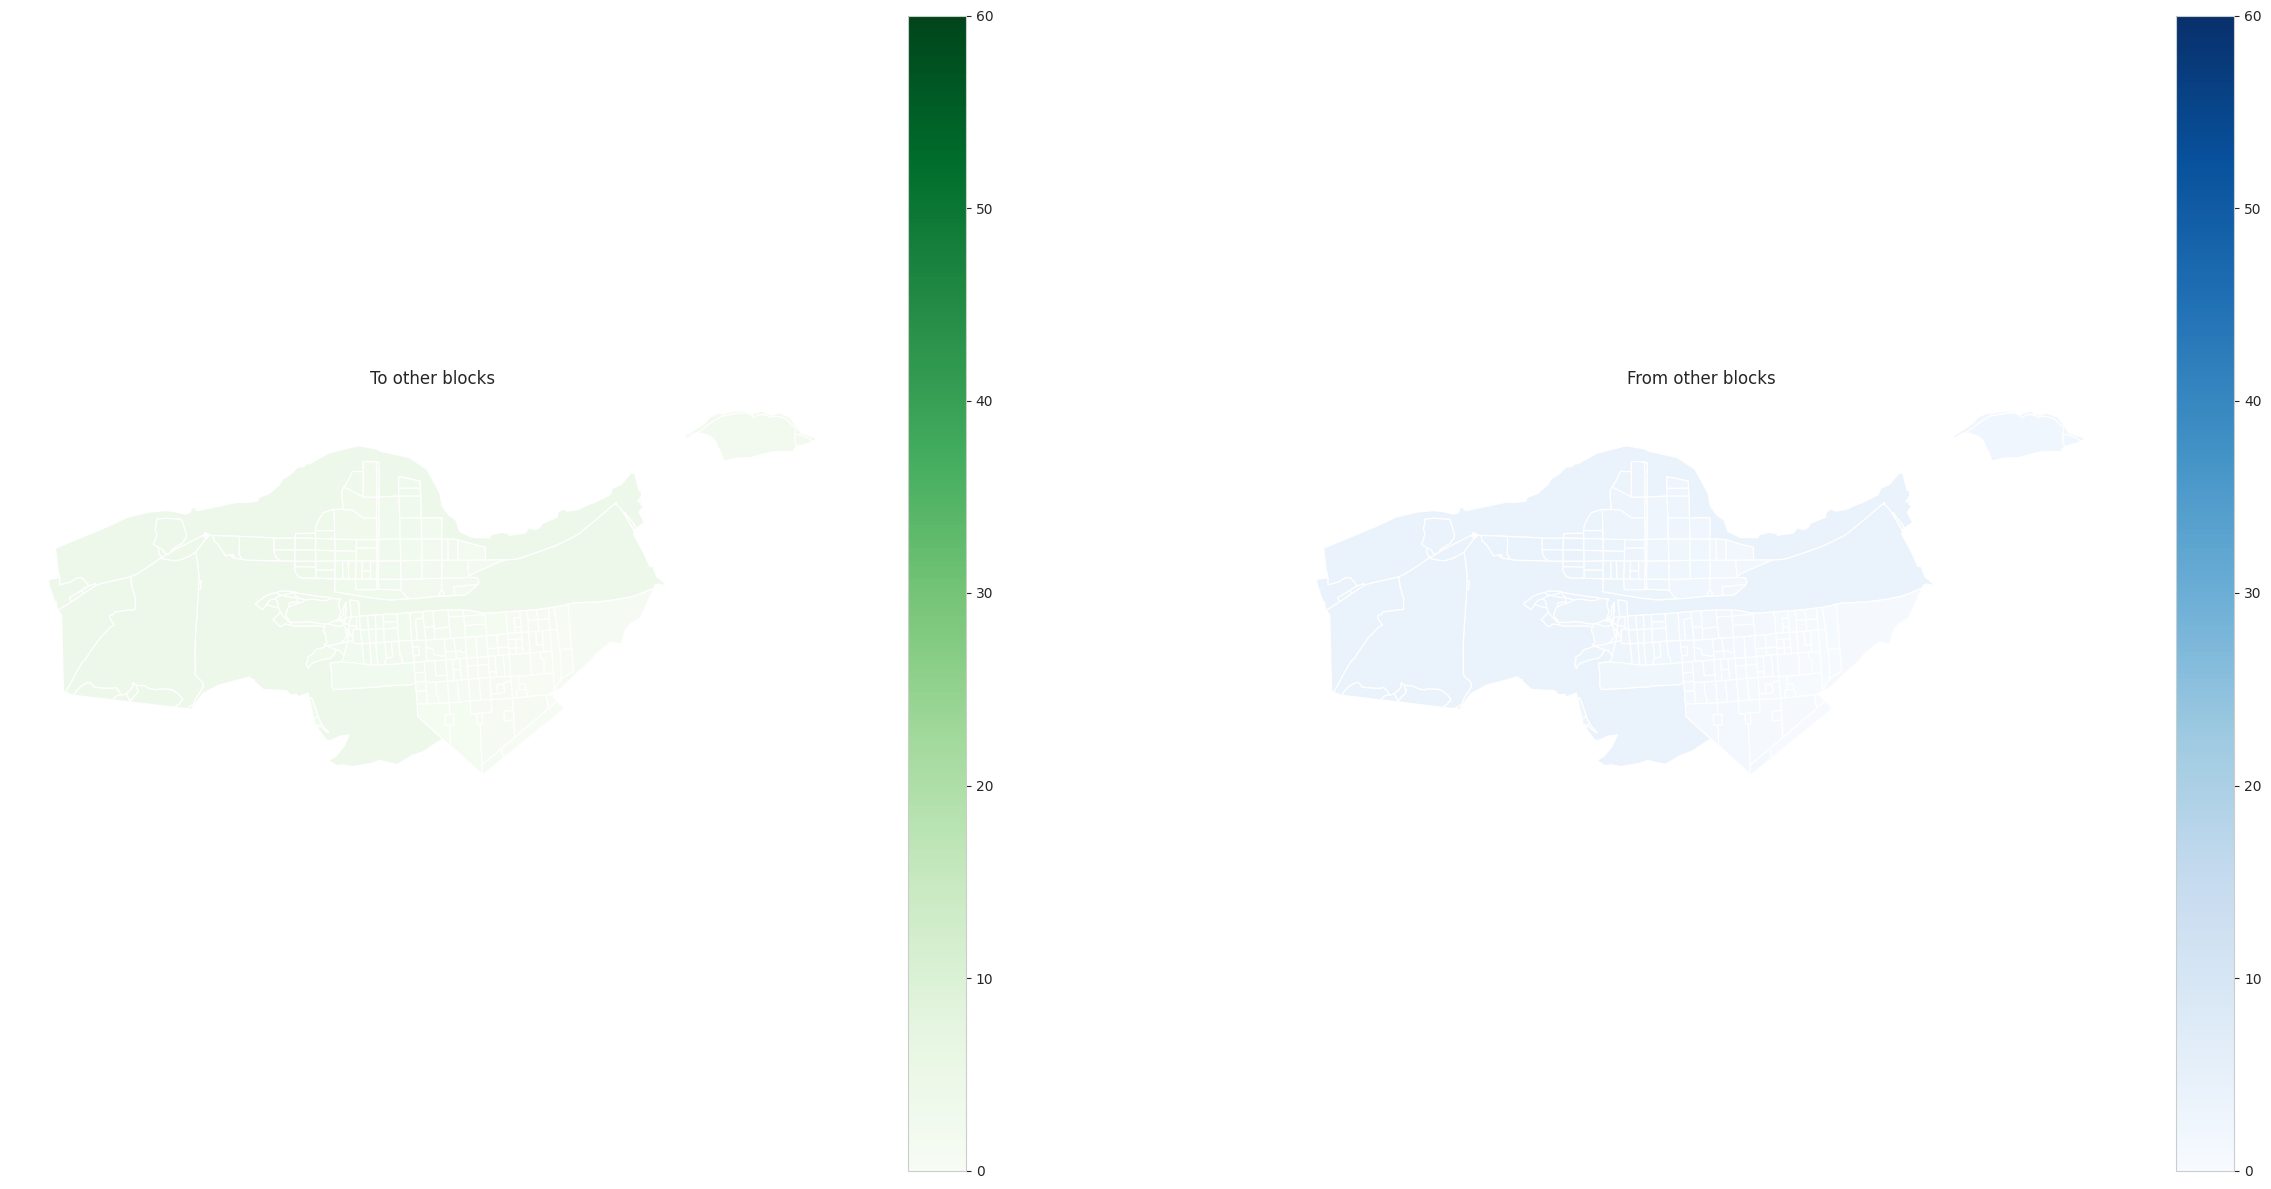

In [32]:
Accessibility.plot(result, linewidth=0.9, figsize=(30,15))

In [33]:
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
buildings = gpd.read_file("/content/building.geojson")

buildings

,index,level_0,level_1,fid,full_id,osm_id,building_left,addr:place,landuse,building:year_built,...,sewerage_cesspools_volume,gas_type,ventilation_type,firefighting_type,drainage_type,Unnamed: 60,id_geo,living_area,population,geometry
0,342,341,0,8176.0,w1020231650,1020231650,yes,None,None,None,...,NaN,None,None,None,None,None,None,96.427461,1.0,"POLYGON ((33.50307 60.73441, 33.50304 60.73449..."
1,1493,1496,0,8185.0,w1020241487,1020241487,yes,None,None,None,...,NaN,None,None,None,None,None,None,169.826100,7.0,"POLYGON ((33.55864 60.72899, 33.55863 60.72909..."
2,2633,2597,0,8248.0,w1020314616,1020314616,apartments,None,None,None,...,NaN,None,None,None,None,None,None,3025.599652,51.0,"POLYGON ((33.54619 60.72019, 33.54620 60.72006..."
3,2635,2599,0,8250.0,w1020314619,1020314619,yes,None,None,None,...,NaN,None,None,None,None,None,None,242.759271,7.0,"POLYGON ((33.53599 60.72222, 33.53600 60.72235..."
4,2636,2600,0,8251.0,w1020314620,1020314620,yes,None,None,None,...,NaN,None,None,None,None,None,None,130.947560,5.0,"POLYGON ((33.53724 60.72220, 33.53725 60.72229..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081,3475,3429,0,8305.0,None,None,None,None,None,None,...,NaN,None,None,None,None,None,None,104.534019,3.0,"POLYGON ((33.56344 60.71892, 33.56356 60.71893..."
2082,3476,3430,0,8306.0,None,None,None,None,None,None,...,NaN,None,None,None,None,None,None,63.176221,2.0,"POLYGON ((33.56357 60.72014, 33.56357 60.72005..."
2083,3479,3433,0,8309.0,None,None,None,None,None,None,...,NaN,None,None,None,None,None,None,40.700594,1.0,"POLYGON ((33.56924 60.71858, 33.56925 60.71852..."
2084,3480,3434,0,8310.0,None,None,None,None,None,None,...,NaN,None,None,None,None,None,None,80.196591,2.0,"POLYGON ((33.56864 60.71856, 33.56876 60.71856..."


In [35]:
buildings = buildings.drop(columns=['id'])

In [36]:
local_crs = buildings.estimate_utm_crs() # определяем локальную систему координат
local_crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [37]:
buildings = buildings.to_crs(local_crs) # переводим здания в локальную систему координат
buildings.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]
buildings.head()

,index,level_0,level_1,fid,full_id,osm_id,building_left,addr:place,landuse,building:year_built,...,sewerage_cesspools_volume,gas_type,ventilation_type,firefighting_type,drainage_type,Unnamed: 60,id_geo,living_area,population,geometry
0,342,341,0,8176.0,w1020231650,1020231650,yes,None,None,None,...,NaN,None,None,None,None,None,None,96.427461,1.0,"POLYGON ((527435.640 6733310.247, 527433.736 6..."
1,1493,1496,0,8185.0,w1020241487,1020241487,yes,None,None,None,...,NaN,None,None,None,None,None,None,169.826100,7.0,"POLYGON ((530471.121 6732731.187, 530470.737 6..."
2,2633,2597,0,8248.0,w1020314616,1020314616,apartments,None,None,None,...,NaN,None,None,None,None,None,None,3025.599652,51.0,"POLYGON ((529800.148 6731745.515, 529801.009 6..."
3,2635,2599,0,8250.0,w1020314619,1020314619,yes,None,None,None,...,NaN,None,None,None,None,None,None,242.759271,7.0,"POLYGON ((529241.989 6731966.559, 529242.251 6..."
4,2636,2600,0,8251.0,w1020314620,1020314620,yes,None,None,None,...,NaN,None,None,None,None,None,None,130.947560,5.0,"POLYGON ((529310.523 6731965.503, 529310.578 6..."


In [39]:
# Сброс индекса, чтобы превратить индексы в обычные столбцы
buildings = buildings.reset_index(drop=True)
# Проверяем результат
buildings.head()

,index,level_0,level_1,fid,full_id,osm_id,building_left,addr:place,landuse,building:year_built,...,sewerage_cesspools_volume,gas_type,ventilation_type,firefighting_type,drainage_type,Unnamed: 60,id_geo,living_area,population,geometry
0,342,341,0,8176.0,w1020231650,1020231650,yes,None,None,None,...,NaN,None,None,None,None,None,None,96.427461,1.0,"POLYGON ((527435.640 6733310.247, 527433.736 6..."
1,1493,1496,0,8185.0,w1020241487,1020241487,yes,None,None,None,...,NaN,None,None,None,None,None,None,169.826100,7.0,"POLYGON ((530471.121 6732731.187, 530470.737 6..."
2,2633,2597,0,8248.0,w1020314616,1020314616,apartments,None,None,None,...,NaN,None,None,None,None,None,None,3025.599652,51.0,"POLYGON ((529800.148 6731745.515, 529801.009 6..."
3,2635,2599,0,8250.0,w1020314619,1020314619,yes,None,None,None,...,NaN,None,None,None,None,None,None,242.759271,7.0,"POLYGON ((529241.989 6731966.559, 529242.251 6..."
4,2636,2600,0,8251.0,w1020314620,1020314620,yes,None,None,None,...,NaN,None,None,None,None,None,None,130.947560,5.0,"POLYGON ((529310.523 6731965.503, 529310.578 6..."


In [40]:
for colums in buildings.columns:
  print(colums)

index
level_0
level_1
fid
full_id
osm_id
building_left
addr:place
landuse
building:year_built
building:levels
addr:street
addr:housenumber
addr:city
name
addr:region
is_living
index_right
address
index_x
address_x
city
postcode
country
street
house
outer_id
index_y
region_id
area_id
city_id
street_id
shortname_region
formalname_region
shortname_area
formalname_area
shortname_city
formalname_city
shortname_street
formalname_street
house_number
building_right
block
letter
address_y
houseguid
management_organization_id
built_year
exploitation_start_year
project_type
house_type
is_alarm
method_of_forming_overhaul_fund
floor_count_max
floor_count_min
entrance_count
elevators_count
energy_efficiency
quarters_count
living_quarters_count
unliving_quarters_count
area_total
area_residential
area_non_residential
area_common_property
area_land
parking_square
playground
sportsground
other_beautification
foundation_type
floor_type
wall_material
basement_area
chute_type
chute_count
electrical_type
el

In [41]:
# Преобразуем столбец 'building:levels' в числовой тип, ошибки будут заменены на NaN
buildings['building:levels'] = pd.to_numeric(buildings['building:levels'], errors='coerce')

# Заполним пропущенные значения (NaN) нулями или другими подходящими значениями
buildings = buildings.fillna(0)

# Добавляем или преобразуем необходимые атрибуты

# 1. Количество этажей (number_of_floors)
buildings['number_of_floors'] = buildings.apply(
    lambda x: x['building:levels'] if x['building:levels'] > 1 else 1,
    axis=1
)

# 2. Площадь застройки (footprint_area) - как площадь геометрии (основание здания)
buildings['footprint_area'] = buildings.geometry.area

# 3. Общая площадь всех этажей (build_floor_area) - footprint_area * number_of_floors
buildings['build_floor_area'] = buildings['footprint_area'] * buildings['number_of_floors']

# 4. Жилая площадь (living_area) и нежилая площадь (non_living_area)
# Жилая площадь будет рассчитываться только для жилых зданий
residential_tags = ['residential', 'house', 'apartments', 'detached', 'terrace', 'dormitory']
buildings['living_area'] = buildings.apply(
    lambda x: 0.8 * x['build_floor_area'] if x['building_left'] in residential_tags else 0,
    axis=1
)

# Нежилая площадь будет 20% от общей площади этажей
buildings['non_living_area'] = buildings['build_floor_area'] - buildings['living_area']

# 5. Население (population) - для жилых зданий
buildings['new_population'] = buildings['population']

# Теперь удалим все остальные столбцы, кроме 'geometry', 'build_floor_area', 'living_area', 'non_living_area',
# 'footprint_area', 'number_of_floors', 'population'
buildings = buildings[['geometry', 'build_floor_area', 'living_area', 'non_living_area',
                       'footprint_area', 'number_of_floors', 'population']]

# Проверим результат
buildings

,geometry,build_floor_area,living_area,non_living_area,footprint_area,number_of_floors,population
0,"POLYGON ((527435.640 6733310.247, 527433.736 6...",86.308186,0.000000,86.308186,86.308186,1,1.0
1,"POLYGON ((530471.121 6732731.187, 530470.737 6...",152.037954,0.000000,152.037954,152.037954,1,7.0
2,"POLYGON ((529800.148 6731745.515, 529801.009 6...",2708.344854,2166.675883,541.668971,902.781618,3,51.0
3,"POLYGON ((529241.989 6731966.559, 529242.251 6...",217.298036,0.000000,217.298036,217.298036,1,7.0
4,"POLYGON ((529310.523 6731965.503, 529310.578 6...",117.214072,0.000000,117.214072,117.214072,1,5.0
...,...,...,...,...,...,...,...
2081,"POLYGON ((530742.881 6731612.425, 530749.486 6...",93.579926,0.000000,93.579926,93.579926,1,3.0
2082,"POLYGON ((530748.471 6731748.117, 530748.698 6...",56.556541,0.000000,56.556541,56.556541,1,2.0
2083,"POLYGON ((531059.536 6731576.358, 531060.018 6...",36.436500,0.000000,36.436500,36.436500,1,1.0
2084,"POLYGON ((531027.080 6731574.137, 531033.471 6...",71.794383,0.000000,71.794383,71.794383,1,2.0


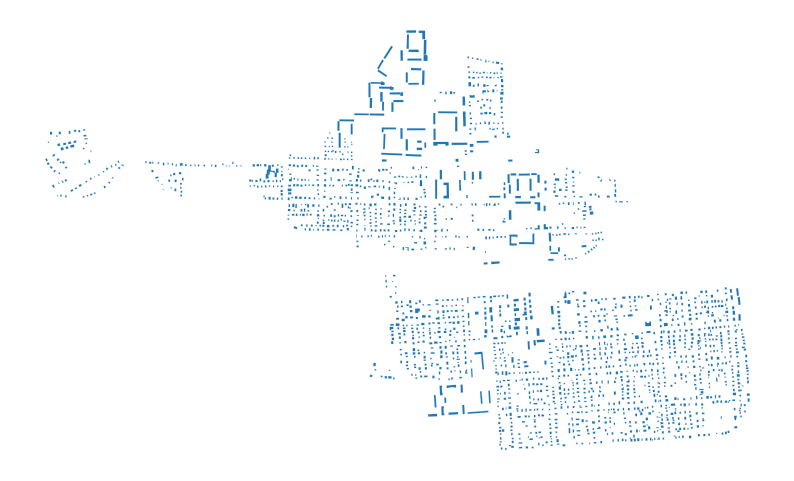

In [42]:
buildings.plot(linewidth=0.1, figsize=(10,10)).set_axis_off()

In [43]:
buildings.to_file("building_new.geojson")

In [44]:
city.update_buildings(buildings)

2025-01-22 17:52:53.097 | INFO     | blocksnet.models.city:update_buildings:1237 - Removing existing blocks from the model
2025-01-22 17:52:53.101 | INFO     | blocksnet.models.city:update_buildings:1241 - Joining buildings and blocks
Update blocks buildings: 100%|██████████| 156/156 [00:01<00:00, 100.09it/s]


,geometry,build_floor_area,living_area,non_living_area,footprint_area,number_of_floors,population


In [45]:
data_path = '/content'

In [46]:
city.to_pickle(os.path.join(data_path,'city_model.pickle'))

In [47]:
from tqdm.auto import tqdm

def remove_inner_polygons(gdf_polygons):
    to_remove = []
    print(len(gdf_polygons))
    for idx, poly1 in tqdm(gdf_polygons.iterrows()):
        for idx2, poly2 in gdf_polygons.iterrows():
            if idx != idx2 and poly1.geometry.contains(poly2.geometry):
                to_remove.append(idx2)
    return gdf_polygons.drop(to_remove)

# Шаг 3: Удаляем близкие центроиды, оставляя одну точку на буфер
def remove_close_centroids(gdf_centroids, buffer_distance=60):
    # Создаем новый GeoDataFrame для хранения итоговых точек
    final_centroids = gpd.GeoDataFrame(columns=gdf_centroids.columns, crs=gdf_centroids.crs)

    # Итерируем по всем точкам
    while not gdf_centroids.empty:
        # Берем первую точку
        current_point = gdf_centroids.iloc[0]

        # Создаем буфер вокруг этой точки
        buffer = current_point.geometry.buffer(buffer_distance)

        # Находим все точки, которые попадают в этот буфер
        close_points = gdf_centroids[gdf_centroids.geometry.within(buffer)]

        # Добавляем одну (например, первую) точку в итоговый результат с помощью concat
        final_centroids = gpd.GeoDataFrame(
            pd.concat([final_centroids, gpd.GeoDataFrame([current_point])], ignore_index=True)
        )

        # Удаляем все точки, попавшие в этот буфер, из исходного списка
        gdf_centroids = gdf_centroids.drop(close_points.index)

    return final_centroids

In [48]:
import os
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point
from blocksnet import ServiceType


school = gpd.read_file('school.geojson')[['geometry', 'capacity']]
school['capacity'] = school['capacity'].apply(int)
school

,geometry,capacity
0,POINT (33.56362 60.71753),1200
1,POINT (33.55266 60.73727),861
2,POINT (33.55607 60.72681),406
3,POINT (33.53599 60.73529),427
4,POINT (33.54862 60.73255),33
5,POINT (33.53655 60.73612),379


In [49]:
city.update_services('school',school.to_crs(city.crs))
city.get_services_gdf()

,geometry,block_id,service_type,capacity,area,is_integrated
0,POINT (530137.581 6733650.983),46,school,861,13000.0,False
1,POINT (530333.007 6732486.681),87,school,406,4000.0,False
2,POINT (529921.367 6733123.221),136,school,33,3200.0,False
3,POINT (529230.165 6733422.950),150,school,427,4000.0,False
4,POINT (529260.117 6733515.223),150,school,379,4000.0,False
5,POINT (530754.045 6731456.867),178,school,1200,13000.0,False


2025-01-22 17:52:57.171 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 15 : 156x5
2025-01-22 17:52:57.328 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2025-01-22 17:52:57.425 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2025-01-22 17:52:57.815 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


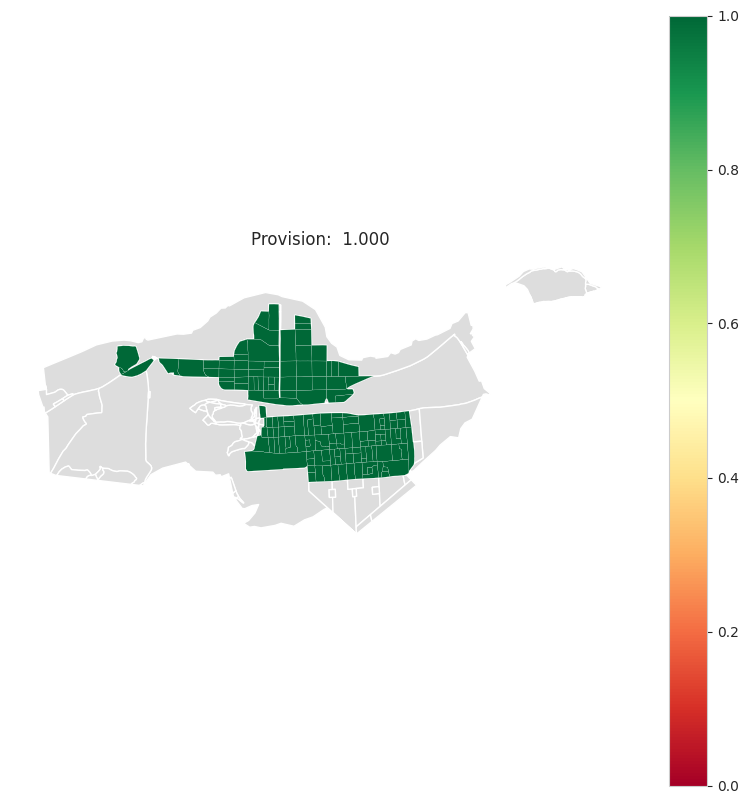

In [50]:
from blocksnet import Provision, ProvisionMethod
service_type = 'school'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)

prov.plot(prov_res)

In [51]:

import pandas as pd

update = {
  176: {
    'population': 3100
  },
  177: {
    'population': 3100
  },
  179: {
    'population': 3100
  },
  180: {
    'population': 3100
  },
  243: {
    'population': 1000
  }
}

update_df = pd.DataFrame.from_dict(update, 'index')
update_df

,population
176,3100
177,3100
179,3100
180,3100
243,1000


In [52]:
upd_result = prov.calculate(service_type, update_df)

2025-01-22 17:52:59.071 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 15 : 161x5
2025-01-22 17:52:59.322 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2025-01-22 17:52:59.425 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2025-01-22 17:52:59.790 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


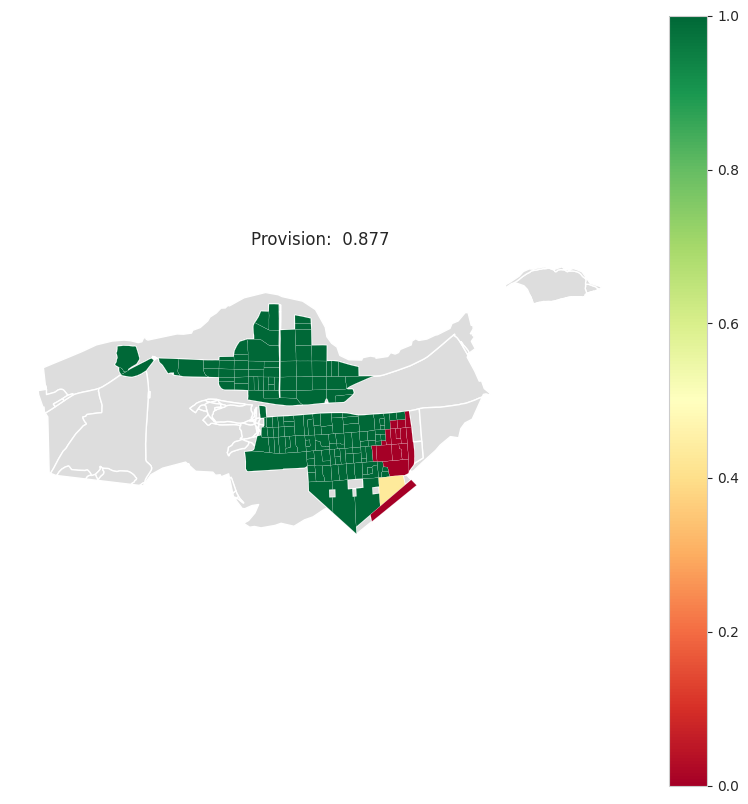

In [53]:
prov.plot(upd_result, figsize=(10,10))

In [54]:
kindergarten = gpd.read_file('kindergarten.geojson')[['geometry', 'capacity']]
kindergarten['capacity'] = kindergarten['capacity'].apply(int)
kindergarten

,geometry,capacity
0,POINT (33.56948 60.71671),400
1,POINT (33.53526 60.73672),124
2,POINT (33.53896 60.73996),149
3,POINT (33.54498 60.73646),181
4,POINT (33.53914 60.73780),112
5,POINT (33.56780 60.72565),165
6,POINT (33.55327 60.73097),96
7,POINT (33.55740 60.71634),400


In [55]:
city.update_services('kindergarten',kindergarten.to_crs(city.crs))
city.get_services_gdf()

,geometry,block_id,service_type,capacity,area,is_integrated
0,POINT (530974.299 6732363.201),14,kindergarten,165,400.0,False
1,POINT (530137.581 6733650.983),46,school,861,13000.0,False
2,POINT (529399.568 6733703.949),47,kindergarten,112,230.0,False
3,POINT (529719.565 6733556.412),51,kindergarten,181,400.0,False
4,POINT (530333.007 6732486.681),87,school,406,4000.0,False
5,POINT (529387.937 6733944.482),89,kindergarten,149,400.0,False
6,POINT (529921.367 6733123.221),136,school,33,3200.0,False
7,POINT (530176.391 6732949.408),139,kindergarten,96,230.0,False
8,POINT (529230.165 6733422.950),150,school,427,4000.0,False
9,POINT (529260.117 6733515.223),150,school,379,4000.0,False


2025-01-22 17:53:01.704 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 7 : 156x8
2025-01-22 17:53:01.920 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2025-01-22 17:53:02.049 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2025-01-22 17:53:02.490 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


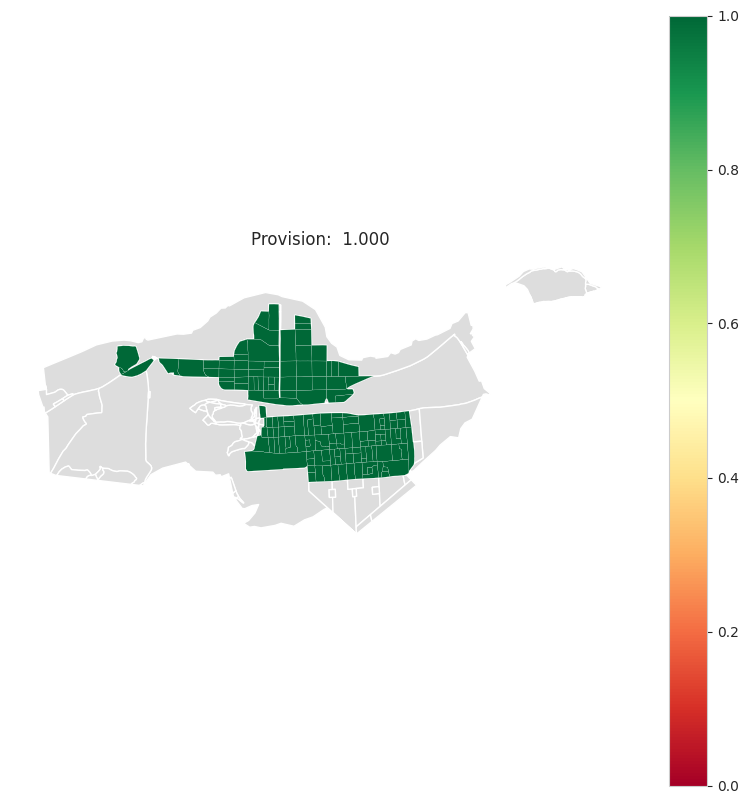

In [56]:
from blocksnet import Provision, ProvisionMethod
service_type = 'kindergarten'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)

prov.plot(prov_res)

In [57]:

import pandas as pd

update = {
  176: {
    'population': 3100
  },
  177: {
    'population': 3100
  },
  179: {
    'population': 3100
  },
  180: {
    'population': 3100
  },
  243: {
    'population': 1000
  }
}

update_df = pd.DataFrame.from_dict(update, 'index')
update_df

,population
176,3100
177,3100
179,3100
180,3100
243,1000


In [58]:
upd_result = prov.calculate(service_type, update_df)

2025-01-22 17:53:04.049 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 7 : 161x8
2025-01-22 17:53:04.184 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2025-01-22 17:53:04.357 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2025-01-22 17:53:04.654 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


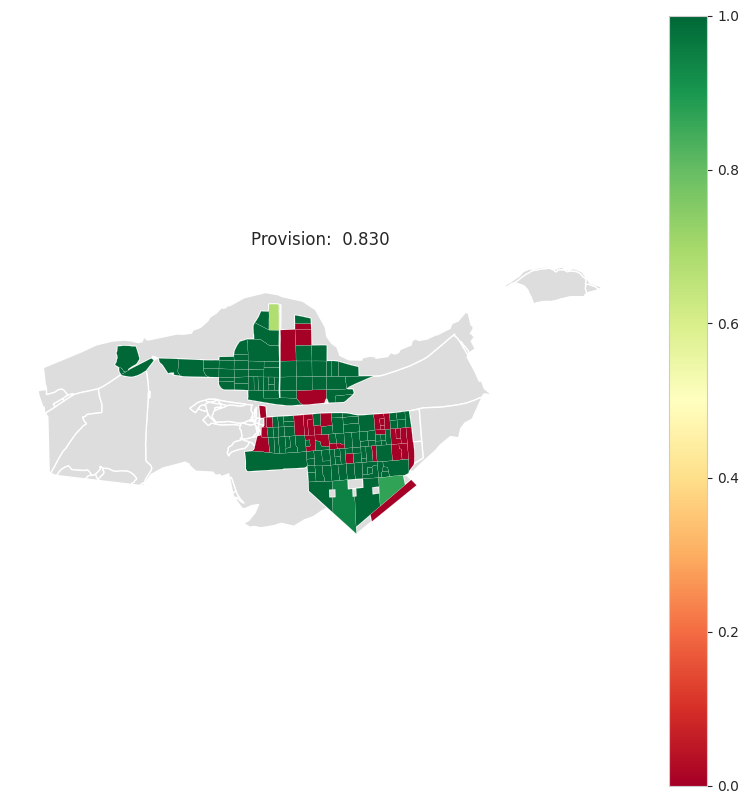

In [59]:
prov.plot(upd_result, figsize=(10,10))

In [60]:
polyclinic = gpd.read_file('polyclinic.geojson')[['geometry', 'capacity']]
polyclinic['capacity'] = polyclinic['capacity'].apply(int)
polyclinic

,geometry,capacity
0,POINT (33.53941 60.74159),170
1,POINT (33.56344 60.71649),450


In [61]:
city.update_services('polyclinic',polyclinic.to_crs(city.crs))
city.get_services_gdf()

,geometry,block_id,service_type,capacity,area,is_integrated
0,POINT (530974.299 6732363.201),14,kindergarten,165,400.0,False
1,POINT (530137.581 6733650.983),46,school,861,13000.0,False
2,POINT (529410.795 6734126.272),46,polyclinic,170,1400.0,False
3,POINT (529399.568 6733703.949),47,kindergarten,112,230.0,False
4,POINT (529719.565 6733556.412),51,kindergarten,181,400.0,False
5,POINT (530333.007 6732486.681),87,school,406,4000.0,False
6,POINT (529387.937 6733944.482),89,kindergarten,149,400.0,False
7,POINT (529921.367 6733123.221),136,school,33,3200.0,False
8,POINT (530176.391 6732949.408),139,kindergarten,96,230.0,False
9,POINT (529230.165 6733422.950),150,school,427,4000.0,False


2025-01-22 17:53:08.109 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 10 : 156x2
2025-01-22 17:53:08.237 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2025-01-22 17:53:08.283 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2025-01-22 17:53:08.707 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


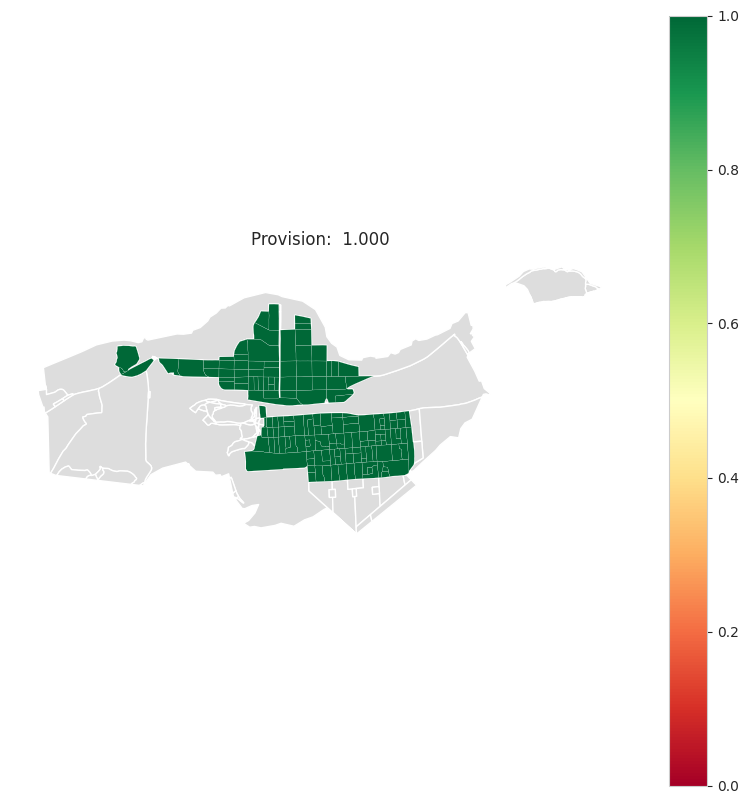

In [62]:
from blocksnet import Provision, ProvisionMethod
service_type = 'polyclinic'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)

prov.plot(prov_res)

In [63]:

import pandas as pd

update = {
  176: {
    'population': 3100
  },
  177: {
    'population': 3100
  },
  179: {
    'population': 3100
  },
  180: {
    'population': 3100
  },
  243: {
    'population': 1000
  }
}

update_df = pd.DataFrame.from_dict(update, 'index')
update_df

,population
176,3100
177,3100
179,3100
180,3100
243,1000


In [64]:
upd_result = prov.calculate(service_type, update_df)

2025-01-22 17:53:11.287 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 10 : 161x2
2025-01-22 17:53:11.345 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2025-01-22 17:53:11.406 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2025-01-22 17:53:11.687 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


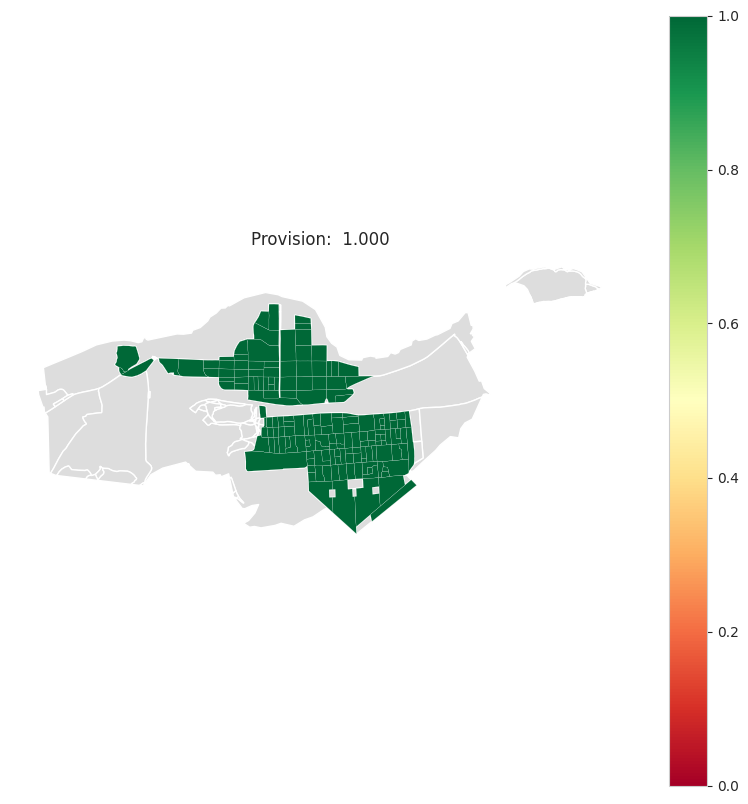

In [65]:
prov.plot(upd_result, figsize=(10,10))